# Solve the problem leveraging MobileNet architecture
In this notebook, we will use the MobileNet architecture for our classification problem.

First, we'll try a simple **feature extraction**. Since the architecture was trained on a different dataset, we do not expect very good performance, but we can use these results as a baseline for the next step: **fine-tuning**.

## Import Libraries
First of all, let's import all the libraries we will need later.

In [1]:
from google.colab import drive
import os
import shutil
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from keras.models import Model
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

## Load dataset from Google Drive

In [2]:
drive.mount('/content/drive', force_remount=True)
!unzip -q "/content/drive/My Drive/Baldi_Cioffo/SplittedDataset.zip" -d "/content"

Mounted at /content/drive


## Set Parameters

In [3]:
DATASET_PATH = "/content/SplittedDataset"
TRAINING_PATH = DATASET_PATH + '/training_set'
TRAINING_ALL_PATH = TRAINING_PATH + '/all'
TRAINING_HEM_PATH = TRAINING_PATH + '/hem'
VALIDATION_PATH = DATASET_PATH + '/validation_set'
TEST_PATH = DATASET_PATH + '/test_set'

LOCAL_MODELS_FOLDER = "/content/models"
if not os.path.exists(LOCAL_MODELS_FOLDER):
  os.makedirs(LOCAL_MODELS_FOLDER)
GLOBAL_MODELS_FOLDER = "/content/drive/My Drive/Baldi_Cioffo/models/mobilenet"
if not os.path.exists(GLOBAL_MODELS_FOLDER):
  os.makedirs(GLOBAL_MODELS_FOLDER)

# Default values to load the dataset
BATCH_SIZE = 32
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

## Utility Functions

In [4]:
def set_seed ():
  ''' 
  set_seed is used to obtain reproducible results using keras during the development phase
  '''
  seed = 24
  # The below is necessary for reproducible results of certain Python hash-based operations.
  os.environ["PYTHONHASHSEED"]="0"
  # The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
  np.random.seed(seed)
  # The below is necessary for starting core Python generated random numbers in a well-defined state.
  rn.seed(seed)
  # The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
  tf.random.set_seed(seed)

def show_training_and_validation_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

def load_training_set (image_height, image_width, batch_size):
  '''
  load_training_set loads the training set from the "training_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the training set
  '''
  return image_dataset_from_directory(
    TRAINING_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_validation_set (image_height, image_width, batch_size):
  '''
  load_validation_set loads the validation set from the "validation_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the validation set
  '''
  return image_dataset_from_directory(
    VALIDATION_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def load_test_set (image_height, image_width, batch_size):
  '''
  load_test_set loads the test set from the "test_set" folder. The images are resized to height x width
  :param image_height: standard height of the images
  :param image_width: standard width of the images
  :param batch_size: size of each batch
  :return the test set
  '''
  return image_dataset_from_directory(
    TEST_PATH,
    image_size = (image_height, image_width),
    batch_size = batch_size,
    shuffle = False,
    class_names = ['hem', 'all']) # explicit ordering of the labels, 0 for hem, 1 for all

def compile_model (model, optimizer='adam', learning_rate = 0.001):
  '''
  compile_model is used to compile the current model
  :param model: model to compile
  :param optimizer: optimizer to be used
  :param learning_rate: learning rate parameter for the optimizer
  '''
  if optimizer == 'adam':
    model.compile(loss="binary_crossentropy",
      optimizer=optimizers.Adam(learning_rate=learning_rate),
      metrics=["accuracy"])
  elif optimizer == 'rmsprop':
    model.compile(loss="binary_crossentropy",
                  optimizer = optimizers.RMSprop(learning_rate=learning_rate),
                  metrics=['accuracy'])
  model.summary()

def run_model (model, model_name, epochs = 20, patience=5, monitor='val_loss'):
  '''
  run_model is used to run the current mode
  :param model: model to run
  :param model_name: name given to save the model
  :param epochs: how many epochs to do
  :param patience: patience value for Early Stopping
  :param monitor: what to monitor for Early Stopping and Model Checkpoint
  '''
  # local save path for the models
  save_path = LOCAL_MODELS_FOLDER + '/' + model_name + '.h5'
  callbacks_list = [
                  keras.callbacks.EarlyStopping(monitor=monitor, patience=patience),
                  keras.callbacks.ModelCheckpoint(
                      filepath = save_path,
                      monitor=monitor,
                      verbose=1,
                      save_best_only=True)
                  ]
  history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset,
                    callbacks=callbacks_list)
  # save on Drive only the best model
  shutil.copy(save_path, GLOBAL_MODELS_FOLDER + '/' + model_name + '.h5')
  show_training_and_validation_performance(history)

def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  y_score = model.predict(test_dataset)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_dataset], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

## Load Dataset
The dataset, properly preprocessed, is now located in the local machine.

In [5]:
set_seed()

At this point we need to transform the images we have on disk into preprocessed tensors. 

We decided to use the size that ResNet-50 expects as input, which is 224x224, and to use batches of size 32.

In [6]:
train_dataset = load_training_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
validation_dataset = load_validation_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)
test_dataset = load_test_set(IMAGE_HEIGHT, IMAGE_WIDTH, BATCH_SIZE)

Found 6396 files belonging to 2 classes.
Found 2132 files belonging to 2 classes.
Found 2133 files belonging to 2 classes.


## Feature extraction

In [ ]:
conv_base = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),
    alpha=1,
    include_top= False,
    weights="imagenet",
)

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
conv_base.trainable = False

### Experiment 1
In this first experiment we try a simple configuration with a single dense layer before the output layer, without regularization techniques.

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model1 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model1)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_6 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_6 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_4 (Flatten)         (None, 62720)             0         
                                                           

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 1.1425 - accuracy: 0.7097
Epoch 00001: val_loss improved from inf to 0.65521, saving model to /content/models/experiment1_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 29s 129ms/step - loss: 1.1425 - accuracy: 0.7097 - val_loss: 0.6552 - val_accuracy: 0.8194
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.8007
Epoch 00002: val_loss improved from 0.65521 to 0.64712, saving model to /content/models/experiment1_feature_extraction.h5
200/200 [==============================] - 25s 125ms/step - loss: 0.6546 - accuracy: 0.8007 - val_loss: 0.6471 - val_accuracy: 0.8194
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.3878 - accuracy: 0.8643
Epoch 00003: val_loss did not improve from 0.64712
200/200 [==============================] - 25s 123ms/step - loss: 0.3878 - accuracy: 0.8643 - val_loss: 0.7316 - val_accuracy: 0.8269
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.3217 - accuracy: 0.8870
Epoch 00004: val_loss did not improve from 0.64712
200/200 [==============================] - 25s 122ms/step - loss: 0.3217 - accuracy: 0

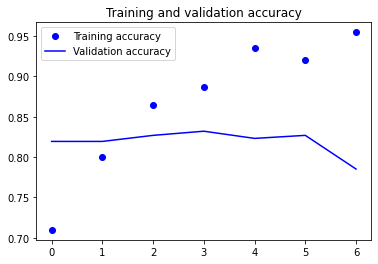

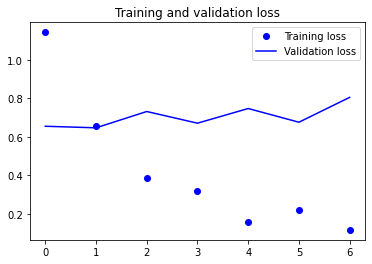

In [ ]:
run_model(model1, 'experiment1_feature_extraction', epochs = 30, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7487    0.6293    0.6838       696
           1     0.8333    0.8977    0.8643      1437

    accuracy                         0.8101      2133
   macro avg     0.7910    0.7635    0.7741      2133
weighted avg     0.8057    0.8101    0.8054      2133



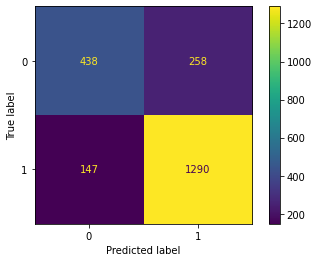

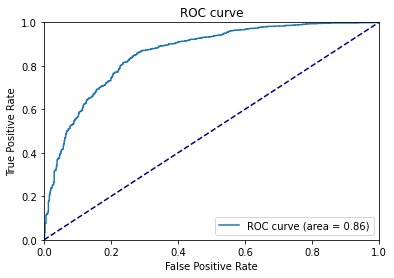

In [7]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment1_feature_extraction.h5'))

### Experiment 2

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                 

Epoch 1/30
200/200 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.6873
Epoch 00001: val_loss improved from inf to 0.46384, saving model to /content/models/experiment2_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 65s 310ms/step - loss: 0.7645 - accuracy: 0.6873 - val_loss: 0.4638 - val_accuracy: 0.8077
Epoch 2/30
200/200 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7356
Epoch 00002: val_loss improved from 0.46384 to 0.45688, saving model to /content/models/experiment2_feature_extraction.h5
200/200 [==============================] - 26s 126ms/step - loss: 0.5459 - accuracy: 0.7356 - val_loss: 0.4569 - val_accuracy: 0.7791
Epoch 3/30
200/200 [==============================] - ETA: 0s - loss: 0.5148 - accuracy: 0.7552
Epoch 00003: val_loss improved from 0.45688 to 0.41699, saving model to /content/models/experiment2_feature_extraction.h5
200/200 [==============================] - 26s 127ms/step - loss: 0.5148 - accuracy: 0.7552 - val_loss: 0.4170 - val_accuracy: 0.8124
Epoch 4/30
200/200 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.7633
Epoch 00004: val_loss did not improve from 0.41699
200/200 [======

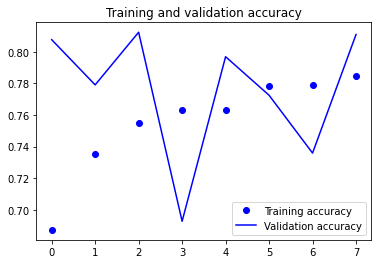

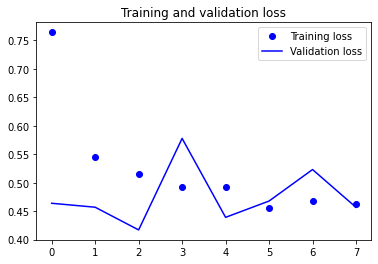

In [ ]:
run_model(model2, 'experiment2_feature_extraction', epochs = 30, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7358    0.6681    0.7003       696
           1     0.8461    0.8838    0.8645      1437

    accuracy                         0.8134      2133
   macro avg     0.7909    0.7759    0.7824      2133
weighted avg     0.8101    0.8134    0.8109      2133



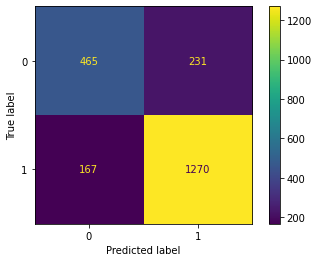

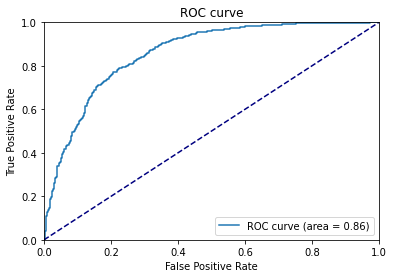

In [8]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment2_feature_extraction.h5'))

### Experiment 3

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                 

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.6560
Epoch 00001: val_loss improved from inf to 0.52367, saving model to /content/models/experiment3_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 29s 128ms/step - loss: 0.6595 - accuracy: 0.6560 - val_loss: 0.5237 - val_accuracy: 0.7402
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5606 - accuracy: 0.7145
Epoch 00002: val_loss improved from 0.52367 to 0.50284, saving model to /content/models/experiment3_feature_extraction.h5
200/200 [==============================] - 25s 124ms/step - loss: 0.5606 - accuracy: 0.7145 - val_loss: 0.5028 - val_accuracy: 0.7650
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5325 - accuracy: 0.7358
Epoch 00003: val_loss did not improve from 0.50284
200/200 [==============================] - 25s 122ms/step - loss: 0.5325 - accuracy: 0.7358 - val_loss: 0.5296 - val_accuracy: 0.7284
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5298 - accuracy: 0.7403
Epoch 00004: val_loss improved from 0.50284 to 0.48687, saving model to /content/models/experiment3_feature_extraction.h5
200/200 [======

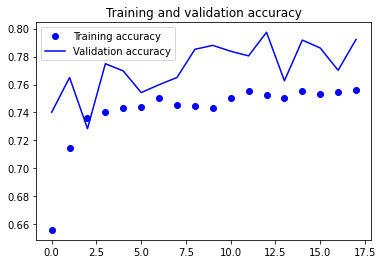

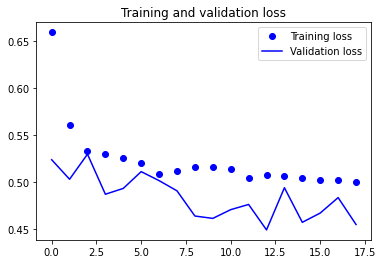

In [ ]:
run_model(model3, 'experiment3_feature_extraction', epochs = 50, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.6902    0.6753    0.6826       696
           1     0.8444    0.8532    0.8487      1437

    accuracy                         0.7951      2133
   macro avg     0.7673    0.7642    0.7657      2133
weighted avg     0.7940    0.7951    0.7945      2133



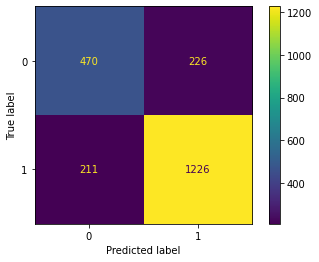

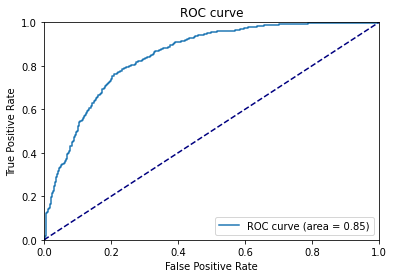

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment3_feature_extraction.h5'))

### Experiment 4

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model4 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model4, optimizer='rmsprop')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6229 - accuracy: 0.7076
Epoch 00001: val_loss improved from inf to 0.49482, saving model to /content/models/Experiment4_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 40s 138ms/step - loss: 0.6229 - accuracy: 0.7076 - val_loss: 0.4948 - val_accuracy: 0.7805
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7541
Epoch 00002: val_loss did not improve from 0.49482
200/200 [==============================] - 25s 125ms/step - loss: 0.5071 - accuracy: 0.7541 - val_loss: 0.5201 - val_accuracy: 0.7720
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.4843 - accuracy: 0.7652
Epoch 00003: val_loss improved from 0.49482 to 0.42817, saving model to /content/models/Experiment4_feature_extraction.h5
200/200 [==============================] - 26s 127ms/step - loss: 0.4843 - accuracy: 0.7652 - val_loss: 0.4282 - val_accuracy: 0.8119
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.7849
Epoch 00004: val_loss did not improve from 0.42817
200/200 [==============================] - 26s 126ms/step - loss: 0.4578 - accuracy: 0

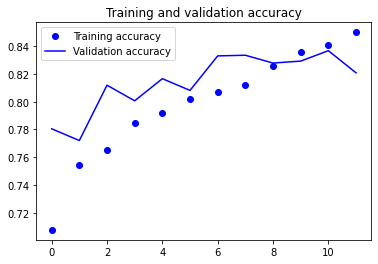

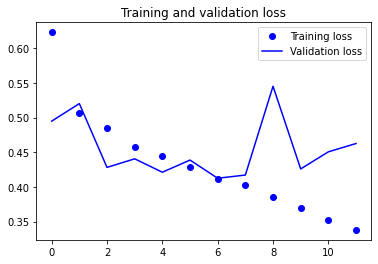

In [ ]:
run_model(model4, "Experiment4_feature_extraction", epochs=50)

Classification report: 
              precision    recall  f1-score   support

           0     0.7858    0.6537    0.7137       696
           1     0.8449    0.9137    0.8780      1437

    accuracy                         0.8289      2133
   macro avg     0.8154    0.7837    0.7958      2133
weighted avg     0.8256    0.8289    0.8244      2133



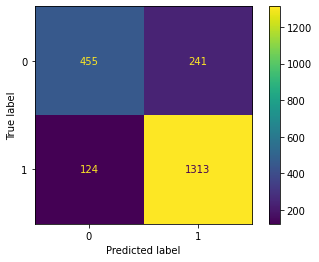

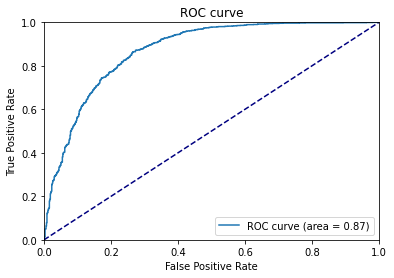

In [9]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/Experiment4_feature_extraction.h5'))

## Fine tuning

### Experiment 5

In [ ]:
fine_tuning = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction.h5'))

setTrainable = False
for layer in fine_tuning.get_layer('mobilenetv2_1.00_224').layers:
    if layer.name in ('block_16_expand'):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

compile_model(fine_tuning, learning_rate=1e-5)

for i, layer in enumerate(fine_tuning.get_layer('mobilenetv2_1.00_224').layers):
    print(i, layer.name, layer.trainable)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                 

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.6873
Epoch 00001: val_loss improved from inf to 0.49195, saving model to /content/models/fine_tuning_4.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 31s 136ms/step - loss: 0.6813 - accuracy: 0.6873 - val_loss: 0.4920 - val_accuracy: 0.7641
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.5827 - accuracy: 0.7362
Epoch 00002: val_loss improved from 0.49195 to 0.48780, saving model to /content/models/fine_tuning_4.h5
200/200 [==============================] - 26s 129ms/step - loss: 0.5827 - accuracy: 0.7362 - val_loss: 0.4878 - val_accuracy: 0.7716
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.7341
Epoch 00003: val_loss did not improve from 0.48780
200/200 [==============================] - 26s 129ms/step - loss: 0.5488 - accuracy: 0.7341 - val_loss: 0.5014 - val_accuracy: 0.7669
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.5357 - accuracy: 0.7453
Epoch 00004: val_loss improved from 0.48780 to 0.48232, saving model to /content/models/fine_tuning_4.h5
200/200 [==============================] - 26s

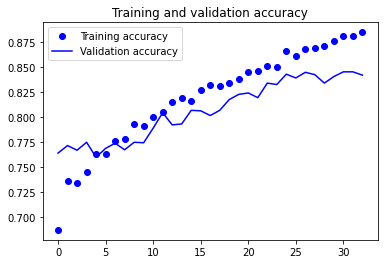

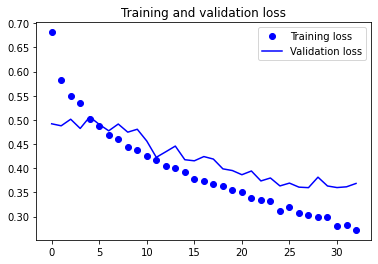

In [ ]:
run_model(fine_tuning, 'experiment5_finetuning', epochs = 100, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7579    0.7601    0.7590       696
           1     0.8836    0.8824    0.8830      1437

    accuracy                         0.8425      2133
   macro avg     0.8208    0.8212    0.8210      2133
weighted avg     0.8426    0.8425    0.8425      2133



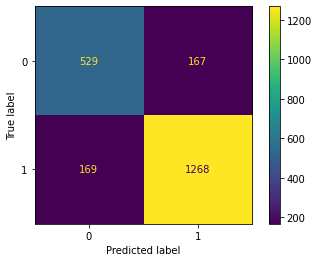

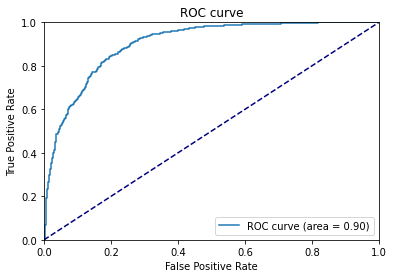

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment5_finetuning.h5'))

### Experiment 6

In [ ]:
fine_tuning = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment2_feature_extraction.h5'))

setTrainable = False
for layer in fine_tuning.get_layer('mobilenetv2_1.00_224').layers:
    if layer.name in ('block_10_expand'):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

compile_model(fine_tuning, learning_rate=1e-5)

for i, layer in enumerate(fine_tuning.get_layer('mobilenetv2_1.00_224').layers):
    print(i, layer.name, layer.trainable)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_10 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_10 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                 

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.7383
Epoch 00001: val_loss improved from inf to 0.76478, saving model to /content/models/fine_tuning.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 35s 174ms/step - loss: 0.5711 - accuracy: 0.7383 - val_loss: 0.7648 - val_accuracy: 0.6285
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4293 - accuracy: 0.8022
Epoch 00002: val_loss improved from 0.76478 to 0.71810, saving model to /content/models/fine_tuning.h5
200/200 [==============================] - 34s 168ms/step - loss: 0.4293 - accuracy: 0.8022 - val_loss: 0.7181 - val_accuracy: 0.6520
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.3439 - accuracy: 0.8452
Epoch 00003: val_loss improved from 0.71810 to 0.67859, saving model to /content/models/fine_tuning.h5
200/200 [==============================] - 34s 168ms/step - loss: 0.3439 - accuracy: 0.8452 - val_loss: 0.6786 - val_accuracy: 0.6759
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.2818 - accuracy: 0.8816
Epoch 00004: val_loss did not improve from 0.67859
200/200 [==============================] - 33s 165

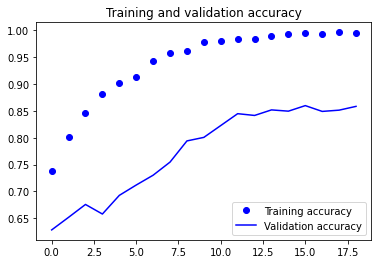

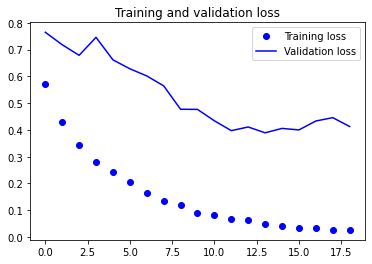

In [ ]:
run_model(fine_tuning, 'experiment6_finetuning', epochs = 100, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7026    0.8420    0.7660       696
           1     0.9153    0.8274    0.8692      1437

    accuracy                         0.8322      2133
   macro avg     0.8090    0.8347    0.8176      2133
weighted avg     0.8459    0.8322    0.8355      2133



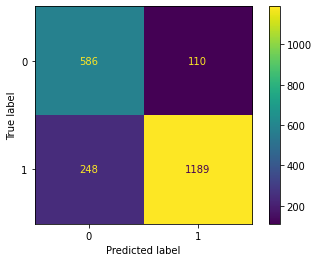

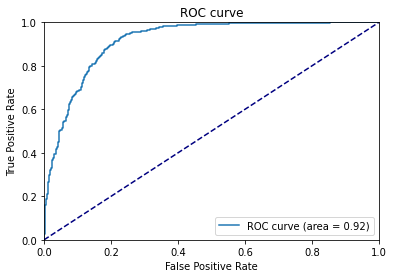

In [10]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment6_finetuning.h5'))

### Experiment 7

In [ ]:
fine_tuning = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment3_feature_extraction.h5'))

setTrainable = False
for layer in fine_tuning.get_layer('mobilenetv2_1.00_224').layers:
    if layer.name in ('block_10_expand'):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

compile_model(fine_tuning, learning_rate=1e-5)

for i, layer in enumerate(fine_tuning.get_layer('mobilenetv2_1.00_224').layers):
    print(i, layer.name, layer.trainable)

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.math.subtract_12 (TFOpLa  (None, 224, 224, 3)      0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                 

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.7863 - accuracy: 0.6831
Epoch 00001: val_loss improved from inf to 0.53581, saving model to /content/models/fine_tuning_2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 38s 170ms/step - loss: 0.7863 - accuracy: 0.6831 - val_loss: 0.5358 - val_accuracy: 0.7331
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.5918 - accuracy: 0.7473
Epoch 00002: val_loss did not improve from 0.53581
200/200 [==============================] - 33s 164ms/step - loss: 0.5918 - accuracy: 0.7473 - val_loss: 0.6016 - val_accuracy: 0.7036
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4917 - accuracy: 0.7805
Epoch 00003: val_loss did not improve from 0.53581
200/200 [==============================] - 33s 164ms/step - loss: 0.4917 - accuracy: 0.7805 - val_loss: 0.6172 - val_accuracy: 0.7054
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.4419 - accuracy: 0.7983
Epoch 00004: val_loss did not improve from 0.53581
200/200 [==============================] - 33s 165ms/step - loss: 0.4419 - accuracy: 0.7983 - val_loss: 0.5883 - val_accuracy: 0.7256
Epoch 5/100
200/200 

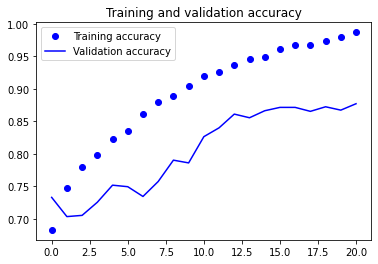

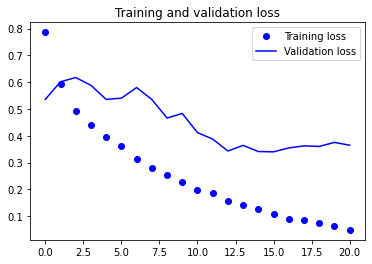

In [ ]:
run_model(fine_tuning, 'experiment7_finetuning', epochs = 100, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.7823    0.8362    0.8083       696
           1     0.9179    0.8873    0.9023      1437

    accuracy                         0.8706      2133
   macro avg     0.8501    0.8617    0.8553      2133
weighted avg     0.8737    0.8706    0.8717      2133



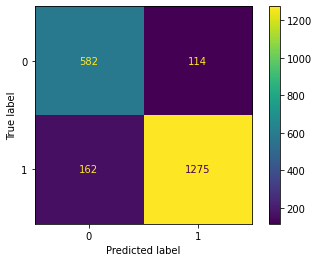

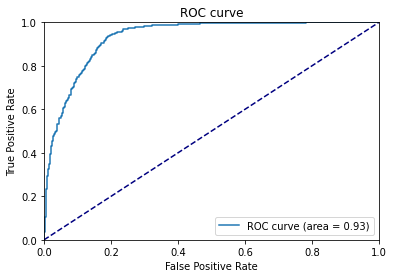

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment7_finetuning.h5'))

## Remove last block

In [ ]:
def get_index_by_layer_name(model, layer_name):
  '''
  get_index_by_layer_name is used to retrieve the index of a specific layer
  :param model: model to check
  :param layer_name: name of the layer we want to get the index of
  :return: the index of the layer named as defined in layer_name
  '''
  for index, layer in enumerate(model.layers):
      if layer.name == layer_name:
          return index

In [ ]:
conv_base = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),
    alpha=1,
    include_top= False,
    weights="imagenet",
)

In [ ]:
base = Model(conv_base.input, conv_base.layers[get_index_by_layer_name(conv_base, 'block_15_add')].output, name='base')
base.trainable = False
base.summary()

Model: "base"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                              

### Feature Extraction

#### Experiment 8

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 base (Functional)           (None, 7, 7, 160)         1364864   
                                                                 
 global_average_pooling2d_1   (None, 160)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.6928
Epoch 00001: val_loss improved from inf to 0.87828, saving model to /content/models/experiment7_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 28s 122ms/step - loss: 0.6490 - accuracy: 0.6928 - val_loss: 0.8783 - val_accuracy: 0.5188
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.5603 - accuracy: 0.7275
Epoch 00002: val_loss improved from 0.87828 to 0.48281, saving model to /content/models/experiment7_feature_extraction.h5
200/200 [==============================] - 24s 119ms/step - loss: 0.5603 - accuracy: 0.7275 - val_loss: 0.4828 - val_accuracy: 0.7720
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.5346 - accuracy: 0.7406
Epoch 00003: val_loss improved from 0.48281 to 0.45200, saving model to /content/models/experiment7_feature_extraction.h5
200/200 [==============================] - 24s 119ms/step - loss: 0.5346 - accuracy: 0.7406 - val_loss: 0.4520 - val_accuracy: 0.7974
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5182 - accuracy: 0.7472
Epoch 00004: val_loss did not improve from 0.45200
200/200 [======

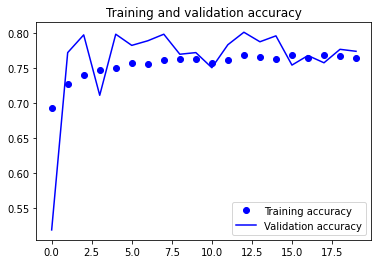

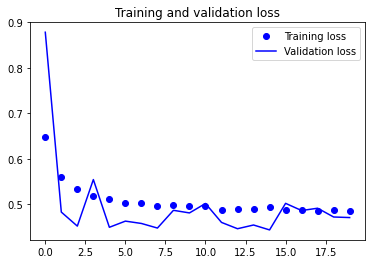

In [ ]:
run_model(model2, 'experiment8_feature_extraction', epochs = 50, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.6789    0.7198    0.6987       696
           1     0.8602    0.8351    0.8475      1437

    accuracy                         0.7975      2133
   macro avg     0.7695    0.7775    0.7731      2133
weighted avg     0.8010    0.7975    0.7989      2133



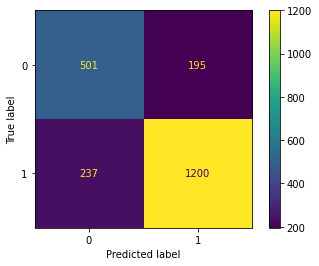

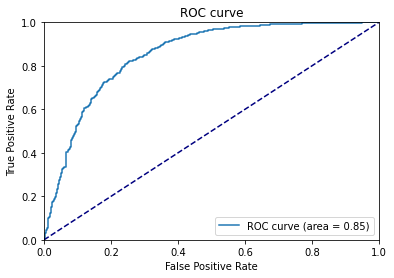

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment8_feature_extraction.h5'))

#### Experiment 9

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = base(x) # feature extraction
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model3 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model3)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_3 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_3 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 base (Functional)           (None, 7, 7, 160)         1364864   
                                                                 
 global_average_pooling2d_2   (None, 160)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.8550 - accuracy: 0.5926
Epoch 00001: val_loss improved from inf to 0.54951, saving model to /content/models/experiment8_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 28s 123ms/step - loss: 0.8550 - accuracy: 0.5926 - val_loss: 0.5495 - val_accuracy: 0.7162
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 0.6985 - accuracy: 0.6559
Epoch 00002: val_loss improved from 0.54951 to 0.52728, saving model to /content/models/experiment8_feature_extraction.h5
200/200 [==============================] - 24s 119ms/step - loss: 0.6985 - accuracy: 0.6559 - val_loss: 0.5273 - val_accuracy: 0.7341
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.6108 - accuracy: 0.6892
Epoch 00003: val_loss did not improve from 0.52728
200/200 [==============================] - 24s 117ms/step - loss: 0.6108 - accuracy: 0.6892 - val_loss: 0.5307 - val_accuracy: 0.7317
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.7015
Epoch 00004: val_loss improved from 0.52728 to 0.51380, saving model to /content/models/experiment8_feature_extraction.h5
200/200 [======

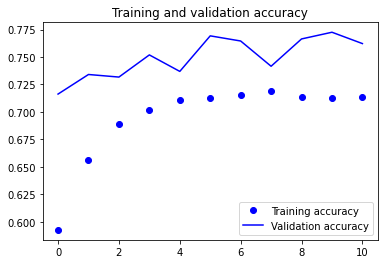

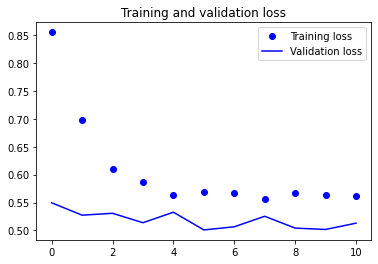

In [ ]:
run_model(model3, 'experiment9_feature_extraction', epochs = 50, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.6356    0.6868    0.6602       696
           1     0.8421    0.8093    0.8254      1437

    accuracy                         0.7693      2133
   macro avg     0.7389    0.7481    0.7428      2133
weighted avg     0.7748    0.7693    0.7715      2133



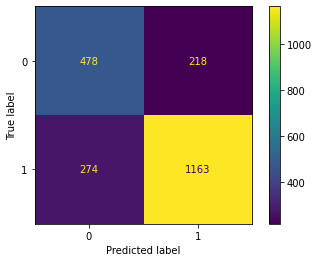

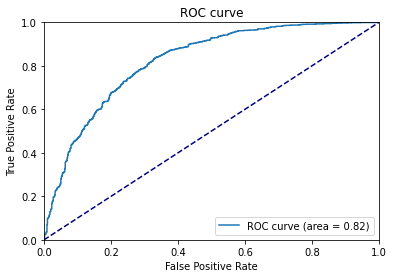

In [11]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment9_feature_extraction.h5'))

#### Experiment 10

In [ ]:
inputs = keras.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = tf.keras.applications.mobilenet.preprocess_input(inputs)
x = base(x) # feature extraction
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model2 = keras.Model(inputs=inputs, outputs=outputs)
compile_model(model2)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 base (Functional)           (None, 7, 7, 160)         1364864   
                                                                 
 flatten_1 (Flatten)         (None, 7840)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               2007

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 12.8050 - accuracy: 0.6731
Epoch 00001: val_loss improved from inf to 5.60214, saving model to /content/models/experiment9_feature_extraction.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 28s 124ms/step - loss: 12.8050 - accuracy: 0.6731 - val_loss: 5.6021 - val_accuracy: 0.7317
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 6.2029 - accuracy: 0.7259
Epoch 00002: val_loss improved from 5.60214 to 3.44431, saving model to /content/models/experiment9_feature_extraction.h5
200/200 [==============================] - 24s 120ms/step - loss: 6.2029 - accuracy: 0.7259 - val_loss: 3.4443 - val_accuracy: 0.7233
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 3.0295 - accuracy: 0.7534
Epoch 00003: val_loss improved from 3.44431 to 1.83257, saving model to /content/models/experiment9_feature_extraction.h5
200/200 [==============================] - 24s 119ms/step - loss: 3.0295 - accuracy: 0.7534 - val_loss: 1.8326 - val_accuracy: 0.7458
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 1.4324 - accuracy: 0.7881
Epoch 00004: val_loss improved from 1.83257 to 0.85339, saving mo

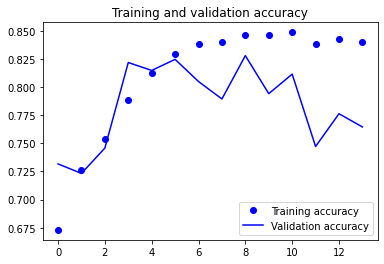

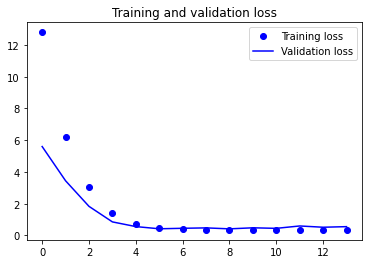

In [ ]:
run_model(model2, 'experiment9_feature_extraction', epochs = 50, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.6189    0.7888    0.6936       696
           1     0.8820    0.7648    0.8192      1437

    accuracy                         0.7726      2133
   macro avg     0.7505    0.7768    0.7564      2133
weighted avg     0.7962    0.7726    0.7782      2133



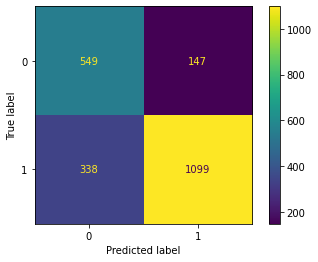

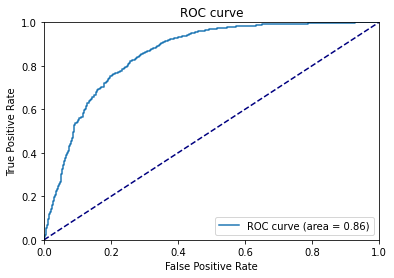

In [ ]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment10_feature_extraction.h5'))

### Fine tuning

#### Experiment 11

In [ ]:
fine_tuning = models.load_model(os.path.join(GLOBAL_MODELS_FOLDER, 'experiment7_feature_extraction.h5'))

setTrainable = False
for layer in fine_tuning.get_layer('base').layers:
    if layer.name in ('block_15_depthwise_BN'):
        setTrainable = True
    if setTrainable == True:
        layer.trainable = True
    else:
      layer.trainable = False

compile_model(fine_tuning, learning_rate=1e-5)

for i, layer in enumerate(fine_tuning.get_layer('base').layers):
    print(i, layer.name, layer.trainable)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 base (Functional)           (None, 7, 7, 160)         1364864   
                                                                 
 global_average_pooling2d_1   (None, 160)              0         
 (GlobalAveragePooling2D)                                        
                                                           

Epoch 1/100
200/200 [==============================] - ETA: 0s - loss: 0.5147 - accuracy: 0.7652
Epoch 00001: val_loss improved from inf to 0.42879, saving model to /content/models/experiment9_fine_tuning_cut.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


200/200 [==============================] - 29s 125ms/step - loss: 0.5147 - accuracy: 0.7652 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 2/100
200/200 [==============================] - ETA: 0s - loss: 0.4850 - accuracy: 0.7706
Epoch 00002: val_loss improved from 0.42879 to 0.42622, saving model to /content/models/experiment9_fine_tuning_cut.h5
200/200 [==============================] - 24s 121ms/step - loss: 0.4850 - accuracy: 0.7706 - val_loss: 0.4262 - val_accuracy: 0.8129
Epoch 3/100
200/200 [==============================] - ETA: 0s - loss: 0.4748 - accuracy: 0.7753
Epoch 00003: val_loss improved from 0.42622 to 0.42404, saving model to /content/models/experiment9_fine_tuning_cut.h5
200/200 [==============================] - 24s 119ms/step - loss: 0.4748 - accuracy: 0.7753 - val_loss: 0.4240 - val_accuracy: 0.8208
Epoch 4/100
200/200 [==============================] - ETA: 0s - loss: 0.4728 - accuracy: 0.7728
Epoch 00004: val_loss improved from 0.42404 to 0.42252, saving model 

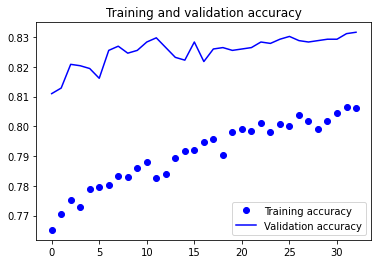

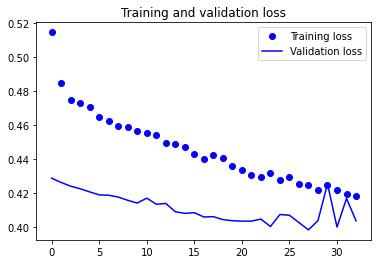

In [ ]:
run_model(fine_tuning, 'experiment11_fine_tuning_cut', epochs = 100, patience=5)

Classification report: 
              precision    recall  f1-score   support

           0     0.6170    0.7615    0.6817       696
           1     0.8697    0.7711    0.8174      1437

    accuracy                         0.7679      2133
   macro avg     0.7433    0.7663    0.7495      2133
weighted avg     0.7872    0.7679    0.7731      2133



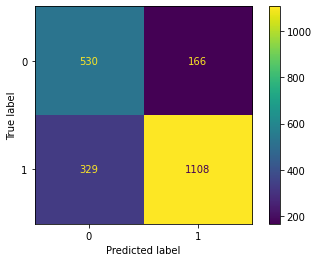

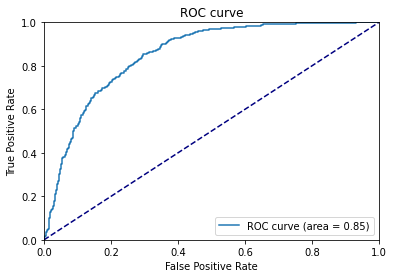

In [12]:
evaluate_model(tf.keras.models.load_model(GLOBAL_MODELS_FOLDER + '/experiment11_fine_tuning_cut.h5'))